In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

C:\Users\muhar\AppData\Local\Temp\ipykernel_9504\2704174492.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("result_model/best_maskrcnn

🚀 Model Loaded Successfully!


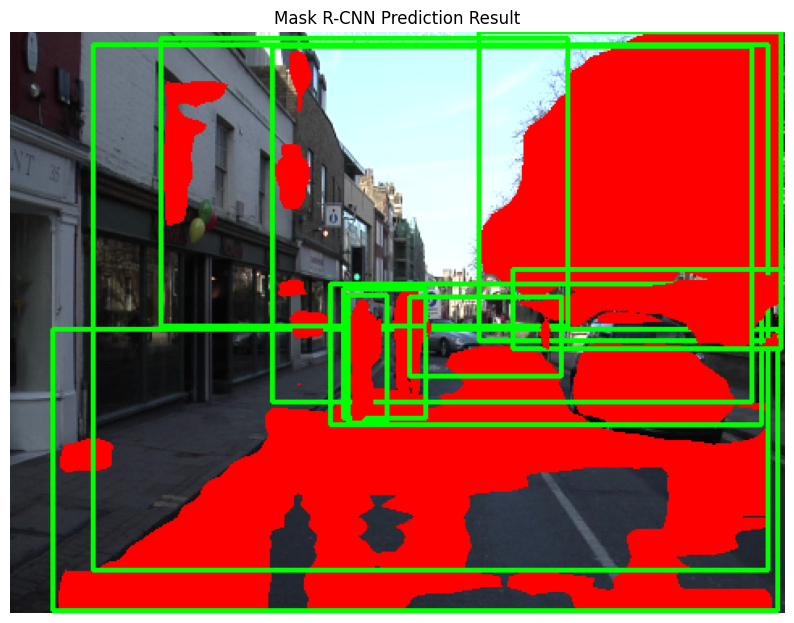

In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision.transforms import ToTensor
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_model(num_classes=2):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=None)
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_channels=1024, num_classes=num_classes
    )
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_channels=256, dim_reduced=256, num_classes=num_classes
    )
    return model

# Load model
model = get_model()
model.load_state_dict(torch.load("result_model/best_maskrcnn_model.pth", map_location=device))
model.to(device)
model.eval()

print("🚀 Model Loaded Successfully!")

# Load image
test_image_path = "dataset/val/images/0016E5_07961.png"
img = cv2.imread(test_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tensor_img = ToTensor()(img_rgb).to(device)

# Prediction
with torch.no_grad():
    prediction = model([tensor_img])[0]

# Draw result
output_img = img_rgb.copy()

for i, score in enumerate(prediction["scores"]):
    if score < 0.5:
        continue
    
    box = prediction['boxes'][i].cpu().numpy().astype(int)
    mask = prediction['masks'][i, 0].cpu().numpy() > 0.5

    output_img[mask] = [255, 0, 0]  # mask red overlay
    cv2.rectangle(output_img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)

# Show result
plt.figure(figsize=(10,8))
plt.imshow(output_img)
plt.title("Mask R-CNN Prediction Result")
plt.axis("off")
plt.show()

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt

ds = load_dataset("cityscapes", name="semantic_segmentation", split="train")

sample = ds[0]

plt.imshow(sample["image"])
plt.title("Cityscapes Sample")
plt.axis("off")
plt.show()

d:\Learning\AI_Indonesia\project_3\Self-Driving-Car\seg_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetNotFoundError: Dataset 'cityscapes' doesn't exist on the Hub or cannot be accessed.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import cv2
import numpy as np
import os

# ---- Albumentations untuk augmentasi ----
import albumentations as A
from albumentations.pytorch import ToTensorV2


# ------------------ Dataset Loader -----------------------
class SegmentationDataset(Dataset):

    def __init__(self, img_dir, mask_dir, augment=False, resize_dim=(512, 1024)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.resize_dim = resize_dim
        self.augment = augment

        all_mask_values = set()
        for file in os.listdir(mask_dir):
            mask = cv2.imread(os.path.join(mask_dir, file), 0)
            all_mask_values.update(np.unique(mask))

        self.mask_values = sorted(list(all_mask_values))
        self.value_to_index = {v: i for i, v in enumerate(self.mask_values)}

        print("📌 Kelas terdeteksi:", self.value_to_index)
        # -------------------------

        # Transform + augmentation
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1,
                               rotate_limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),
            ToTensorV2()
        ])

        # Transform only resize → no augmentation (untuk validation)
        self.transform_no_aug = A.Compose([
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(
            self.mask_dir, img_name.replace(".jpg", ".png"))

        # Load image (BGR→RGB)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(mask_path, 0)

        # ---- Resize agar divisible by 16 ----
        img = cv2.resize(img, self.resize_dim)
        mask = cv2.resize(mask, self.resize_dim,
                          interpolation=cv2.INTER_NEAREST)

        # ---- Apply augmentation (training only) ----
        if self.augment:
            transformed = self.transform(image=img, mask=mask)
        else:
            transformed = self.transform_no_aug(image=img, mask=mask)

        img = transformed["image"].float()
        mask = transformed["mask"]

        # -------------------------
        # 🔥 Convert grayscale → class label index
        # -------------------------
        mask = np.vectorize(self.value_to_index.get)(mask)
        # print(np.unique(mask))
        return img, torch.tensor(mask, dtype=torch.long)


# ------------------ UNET MODEL -----------------------
class UNet(nn.Module):

    def __init__(self, num_classes=12):
        super(UNet, self).__init__()

        def block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels,
                          kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = block(128, 64)

        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def crop_to_match(self, enc, dec):
        _, _, h, w = dec.shape
        return enc[:, :, :h, :w]

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        e4 = self.crop_to_match(e4, d4)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.crop_to_match(e3, d3)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.crop_to_match(e2, d2)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.crop_to_match(e1, d1)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        return self.final_layer(d1)

In [6]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# (Copy class SegmentationDataset dan UNet dari script kamu ke atas cell ini)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(num_classes=12).to(device)
model.load_state_dict(torch.load(
    "result_unet/best_unet_model.pth", map_location=device))
model.eval()

print("🔥 Model loaded and ready on", device.upper())

🔥 Model loaded and ready on CUDA


C:\Users\muhar\AppData\Local\Temp\ipykernel_9504\2426610029.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


In [7]:
dataset_path = "dataset"

test_data = SegmentationDataset(
    img_dir=f"{dataset_path}/val/images",
    mask_dir=f"{dataset_path}/val/masks",
    augment=False
)

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

print("📁 Loaded validation samples:", len(test_data))

📌 Kelas terdeteksi: {np.uint8(0): 0, np.uint8(1): 1, np.uint8(2): 2, np.uint8(3): 3, np.uint8(4): 4, np.uint8(5): 5, np.uint8(6): 6, np.uint8(7): 7, np.uint8(8): 8, np.uint8(9): 9, np.uint8(10): 10, np.uint8(11): 11}
📁 Loaded validation samples: 101


d:\Learning\AI_Indonesia\project_3\Self-Driving-Car\seg_env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [8]:
COLOR_MAP = np.array([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0]
], dtype=np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


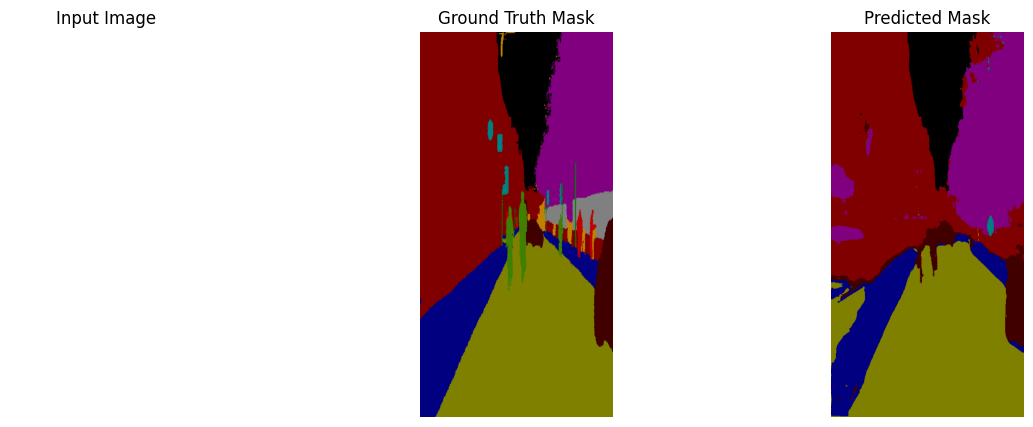

In [9]:
def show_prediction(model, loader):
    model.eval()
    with torch.no_grad():
        for img, mask in loader:
            img = img.to(device)

            pred = model(img)
            pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

            # Convert to colors
            pred_color = COLOR_MAP[pred]
            true_color = COLOR_MAP[mask.squeeze().numpy()]

            img_np = img.cpu().numpy()[0].transpose(1, 2, 0)

            # Plot
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(img_np)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth Mask")
            plt.imshow(true_color)
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_color)
            plt.axis("off")

            plt.show()
            break  # tampilkan satu dulu


show_prediction(model, test_loader)

C:\Users\muhar\AppData\Local\Temp\ipykernel_9504\2410118486.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

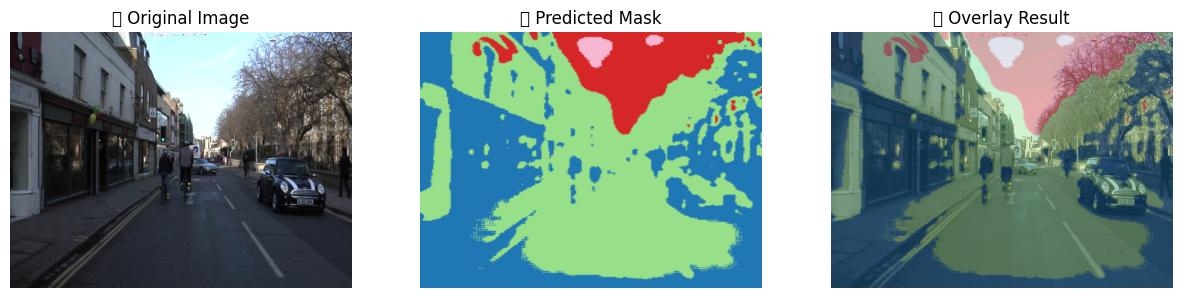

In [17]:
import torch
import numpy as np
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from simple_unet import UNet   # pastikan ini sesuai file model

# ------------------------------
# CONFIG
# ------------------------------
model_path = "result_unet/best_unet_model.pth"
image_path = "dataset/val/images/0016E5_07961.png"
num_classes = 12
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------
# LOAD MODEL
# ------------------------------
model = UNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ------------------------------
# LOAD IMAGE & PREPROCESS
# ------------------------------
orig_img = cv2.imread(image_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# Resize for model
img_resized = cv2.resize(orig_img, (256, 256))

# Convert to tensor (0–1 range)
img_tensor = ToTensor()(img_resized).to(device)

# Normalize using torchvision (correct way)
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

img_tensor = normalize(img_tensor).unsqueeze(0)

# ------------------------------
# MODEL INFERENCE
# ------------------------------
with torch.no_grad():
    output = model(img_tensor)
    pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# ------------------------------
# COLOR VISUALIZATION
# ------------------------------


def create_color_mask(mask):
    cmap = plt.get_cmap("tab20")
    colored = cmap(mask / num_classes)[:, :, :3]
    return (colored * 255).astype(np.uint8)


pred_color = create_color_mask(pred_mask)

# Resize back to original resolution for nicer overlay
pred_color = cv2.resize(pred_color, (orig_img.shape[1], orig_img.shape[0]))

overlay = cv2.addWeighted(orig_img, 0.6, pred_color, 0.4, 0)

# ------------------------------
# SHOW RESULT
# ------------------------------
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title("🖼 Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_color)
plt.title("🎨 Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("🔍 Overlay Result")
plt.axis("off")

plt.show()